# Importações

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
import warnings
warnings.filterwarnings("ignore")

# Não Supervisionado

# Lendo dataset

In [2]:
# Carregar o conjunto de dados
data = pd.read_csv('../../Datasets/Mall_Customers.csv',index_col='CustomerID')
data

,Genre,Age,Annual_Income_(k$),Spending_Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Genre               200 non-null    object
 1   Age                 200 non-null    int64 
 2   Annual_Income_(k$)  200 non-null    int64 
 3   Spending_Score      200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [4]:
data.isna().sum()

Genre                 0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64

In [5]:
data.duplicated().sum()

0

Aqui damos uma olhada no dataset para ver como os dados estão

In [6]:
data.describe()

,Age,Annual_Income_(k$),Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


# KMeans

## Função que executa o kmeans em um dataset X calculando k medias

In [7]:
def calculateKMeans(dataset,n_clusters):
    model = KMeans(n_clusters=n_clusters,random_state=15)
    model.fit(dataset)
    return model    

# Calculando quantidade de clusters

- Inicialmente a quantidade de clusters é limitada a raiz quadrada do número de amostras dividido por 2.
- Depois calculamos a quantidade de clusters ideal usando o método do cotovelo
- Depois calculamos a quantidade ideal de clusters usando o método da silhueta numérico e visual

In [3]:
limit = int((data.shape[0]//2)**0.5)
limit

10

## Cotovelo

Com o método do cotovelo avaliamos no gráfico onde a melhora nos níveis de variação começa a cair mais devagar.
Como o KMeans calcula a distância das observações até o centro do agrupamento que ela pertence, o ideal é que essa distância seja a menor viável. Matematicamente falando, nós estamos buscando uma quantidade de agrupamentos em que a soma dos quadrados intra-clusters (do inglês, within-clusters sum-of-squares (wcss)) seja a menor possível, sendo zero o resultado ótimo.

In [9]:
# Selecionar só 2 colunas para visualização
selected_columns = ['Annual_Income_(k$)', 'Spending_Score']
df = data[selected_columns]

wcss = []
for i in range(1, 11):
    kmeans = calculateKMeans(df,i)
    # método inércia, retorna o wcss do modelo
    wcss.append(kmeans.inertia_)

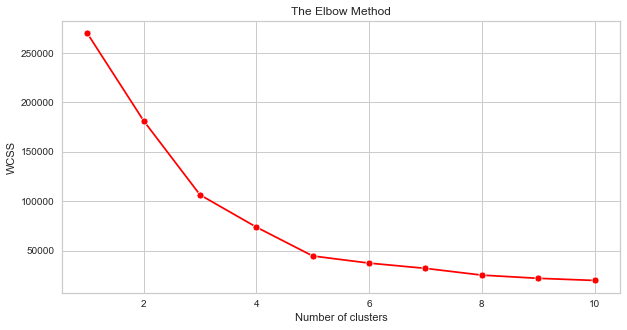

In [10]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
model =  KMeans(init = 'k-means++', random_state=15)
visualizer = KElbowVisualizer(model, k=(2,limit))

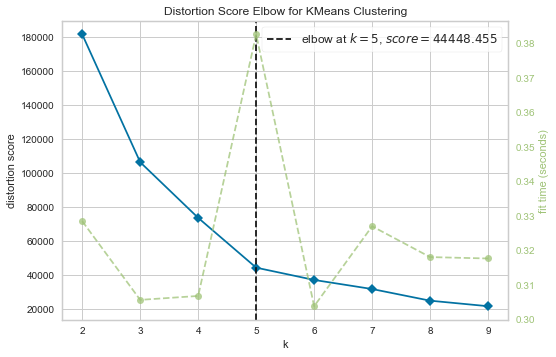

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
visualizer.fit(df)
visualizer.show()

## Silhueta

Método de silhueta observando a média dos valores de silhueta, quanto maior a média dos valores de silhueta, melhor a distribuição

In [13]:
for k in range(2, limit+1):
    model = calculateKMeans(df,k)
    pred = model.predict(df)
    score = silhouette_score(df, pred)

    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))

Silhouette Score for k = 2: 0.297
Silhouette Score for k = 3: 0.468
Silhouette Score for k = 4: 0.493
Silhouette Score for k = 5: 0.554
Silhouette Score for k = 6: 0.540
Silhouette Score for k = 7: 0.455
Silhouette Score for k = 8: 0.458
Silhouette Score for k = 9: 0.457
Silhouette Score for k = 10: 0.450


Método de silhueta observando todos os valores graficamente

Para observar graficamente olhamos o tamanho de cada cluster, considerando se estão com quantidades uniformes ou não, se os clusters possuem scores acima da média(linha tracejada vermelha ou não) e como está a distribuição dos valores (valores mais positivos são melhores )

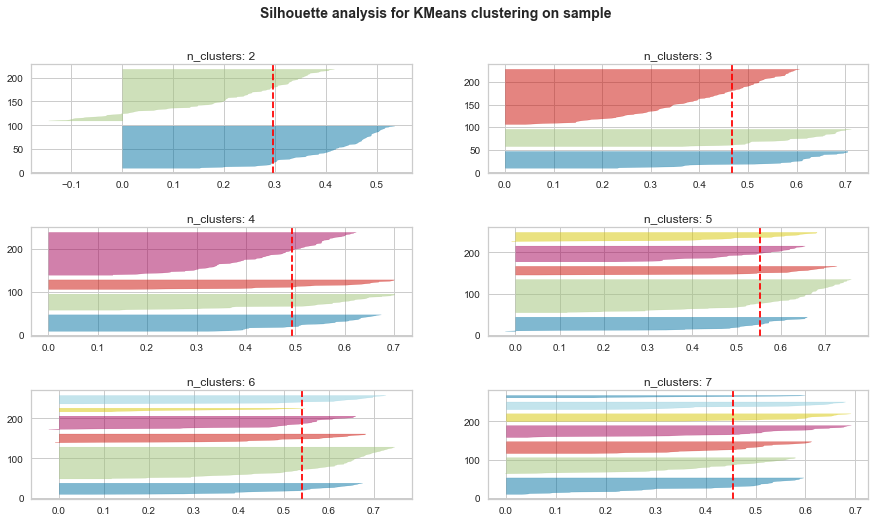

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
count = 2
for axes in ax:
    for axe in axes:
        axe.set_title(f"n_clusters: {count}")
        count+= 1
    
    
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Cria a instância KMeans para diferentes números de clusters
    '''
    km = calculateKMeans(df,i)
    q, mod = divmod(i, 2)
    #print('q:' +str(q))
    #print('mod:' +str(mod))
    
    '''
    Cria a instância SilhouetteVisualizer com a instância KMeans e dá um fit no visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample",
        fontsize=14,
        fontweight="bold",
    )

Com a silhueta e cotovelo podemos ver que o número de clusters ideal para esse problema é 5, visto que os clusters possuem tamanhos mais uniformes, valores acima da média e não possuem muitos valores negativos.

In [15]:
kmeans = calculateKMeans(df,5)

In [16]:
predictions = kmeans.predict(df)

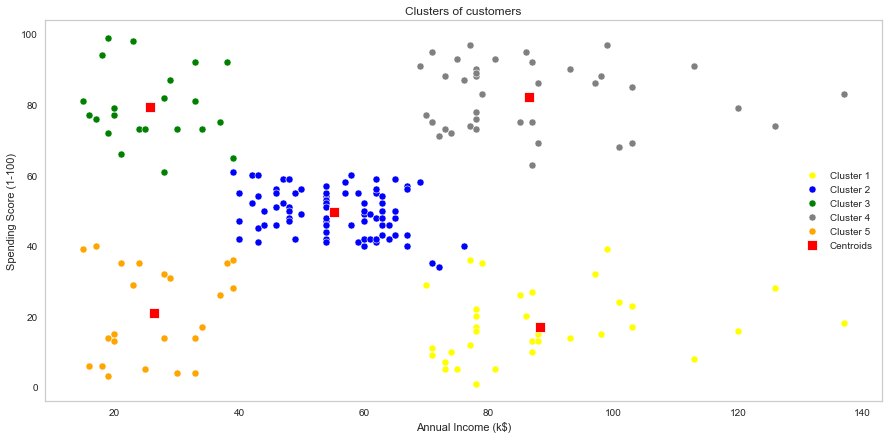

In [17]:
# Visualização dos grupos
plt.figure(figsize=(15,7))

sns.scatterplot(df[predictions == 0]['Annual_Income_(k$)'].values, df[predictions == 0]['Spending_Score'].values, color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(df[predictions == 1]['Annual_Income_(k$)'].values, df[predictions == 1]['Spending_Score'].values, color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(df[predictions == 2]['Annual_Income_(k$)'].values, df[predictions == 2]['Spending_Score'].values, color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(df[predictions == 3]['Annual_Income_(k$)'].values, df[predictions == 3]['Spending_Score'].values, color = 'grey', label = 'Cluster 4',s=50)
sns.scatterplot(df[predictions == 4]['Annual_Income_(k$)'].values, df[predictions == 4]['Spending_Score'].values, color = 'orange', label = 'Cluster 5',s=50)
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red',label = 'Centroids',s=100,marker=',')

plt.grid(False)
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

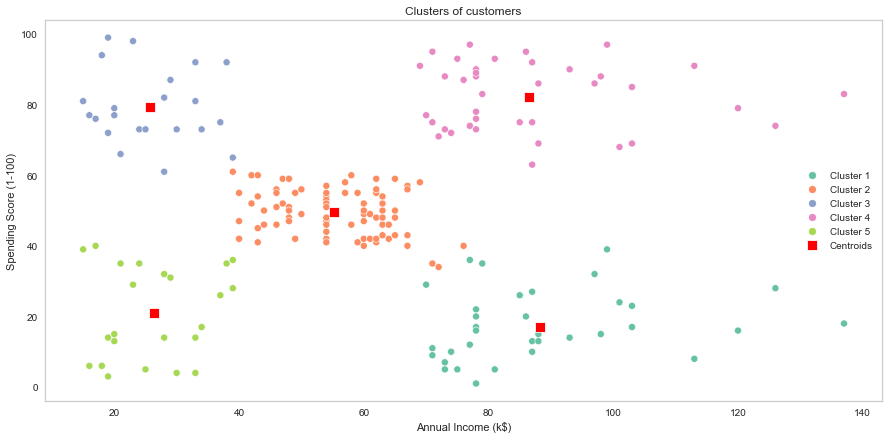

In [18]:
# Visualização dos grupos

plt.figure(figsize=(15,7))

df['predictions'] = predictions
df['label_predictions'] = pd.cut(df['predictions'], bins=5, labels=[f'Cluster {i}' for i in range(1, 6)])

sns.scatterplot(df['Annual_Income_(k$)'].values, df['Spending_Score'].values, hue = df['label_predictions'].values,palette='Set2',s=50)
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red',label = 'Centroids',s=100,marker=',')

plt.grid(False)
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()